# Figure 1 (Segregated E populations)
#### This file runs the simulations and recreates Fig 1D, 1E and 1F

In [1]:
from KeyFunctions.SimulationFunctions import *
from KeyFunctions.TheoryFunctions import *

import matplotlib.pyplot as plt
from tqdm import tqdm

### Default parameters for this file
#### This will simulate the system with two excitatory populations with weak cross-connections

In [2]:
# Steady state
r_bar = np.array([[30],[30]])
r0 = r_bar # initial condition

# Time constants
tau_E=15
tau = np.array([[tau_E], [tau_E]])

# Strength and structure of noise
sigE=1; c=0.5 

# 'Diffusion' matrix for the noise term
D_private = np.diag([np.sqrt(1-c)*sigE, np.sqrt(1-c)*sigE])
D_shared = np.array([np.sqrt(c)*sigE,np.sqrt(c)*sigE])
DMatrix = np.c_[D_private,D_shared]

# Connectivity parameters
Wee=0.5; alpha = 0.15
W = np.block([[Wee, alpha*Wee],
              [alpha*Wee, Wee]])

# Numerics
totalTimeShort=2500 
numTrials = 30
totalTime = 10000
dt=.01

### Fig 1D
#### Run the system around steady state for 2.5 seconds

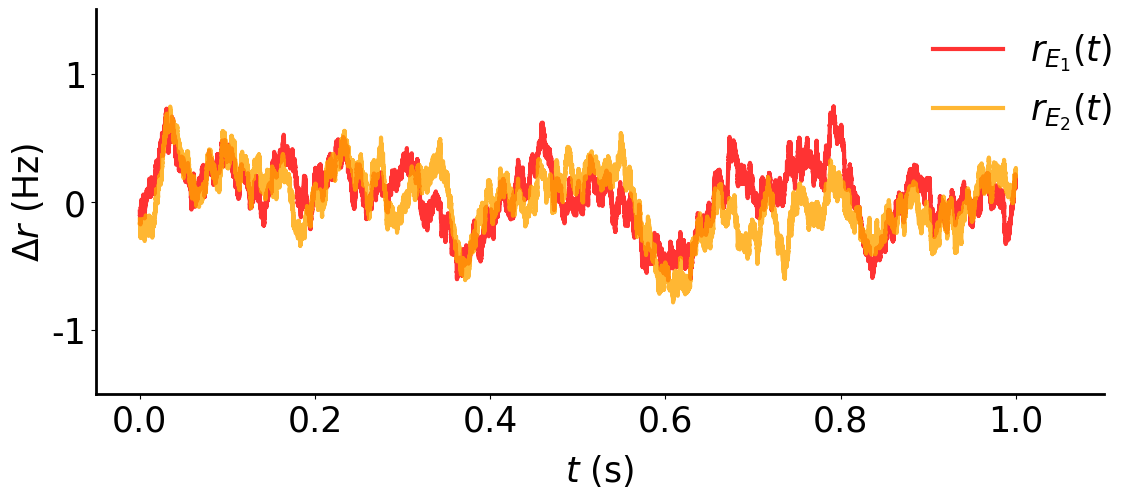

In [8]:
np.random.seed(221000) # Seed the random number generator to ensure consistency
Rates, timeVec = global_inh_model(r0, r_bar, totalTimeShort, dt, W, tau, DMatrix)

# Plot the results
startPlot = 1 # seconds; discard the first second of simulation time for the plot
endPlot = 2
validTimes= (timeVec>=startPlot) & (timeVec<=endPlot)

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(timeVec[validTimes]-1, Rates[0,validTimes], color='red', linestyle='-', linewidth=3, alpha=.8, label=r'$r_{E_1}(t)$')
ax.plot(timeVec[validTimes]-1, Rates[1,validTimes], color='orange', linestyle='-', linewidth=3, alpha=.8, label=r'$r_{E_2}(t)$')

ax.spines.left.set_linewidth(2)
ax.spines.bottom.set_linewidth(2)
ax.spines.right.set_color('none')
ax.spines.top.set_color('none')

ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.set_xlabel(r'$t$ (s)', fontsize=25, labelpad=10)
#ax.set_ylabel(r'firing rate (Hz) ', fontsize=25)
ax.set_ylabel(r'$\Delta r$ (Hz)', fontsize=25)
ax.set_ylim(28.5,31.5)
ax.yaxis.set_ticks([29, 30, 31])
ax.yaxis.set_ticklabels(['-1', '0', '1'])

ax.set_xlim(-0.05,1.1)

plt.legend(bbox_to_anchor=(.8,.6), fontsize=25, frameon=False)

plt.show()

### Fig 1E and 1F
#### Simulations to estimate cross-cov
In order to get an estimate for the cross-covariances, we need to run multiple trials. Run those here. Note: This may take a few minutes to run all trials

In [4]:
np.random.seed(221003) # Seed the random number generator to ensure consistency

RatesAll = np.zeros((2,round(totalTime/dt+1),numTrials))
for i in tqdm(range(numTrials)):
    Rates, timeVec = global_inh_model(r0, r_bar, totalTime, dt, W, tau, DMatrix)
    
    RatesAll[:,:,i]=Rates

100%|███████████████████████████████████████████| 30/30 [01:55<00:00,  3.85s/it]


#### Calculate the auto- and cross-correlations from the simulation data

In [9]:
cov11 = np.zeros((numTrials,round(totalTime/dt*2+1)))
cov12 = np.zeros((numTrials,round(totalTime/dt*2+1)))
for i in tqdm(range(numTrials)):
    cov11[i,:],simLags = xcov(RatesAll[0,:,i],RatesAll[0,:,i])
    cov12[i,:],_ = xcov(RatesAll[0,:,i],RatesAll[1,:,i])

aveCov11 = np.mean(cov11,axis=0)
aveCov12 = np.mean(cov12,axis=0)   

#Adjust for the time lags (for plotting purposes)
timeWindow = (simLags*0.01>=-200) & (simLags*dt<200)
simLagsWindowed = simLags[timeWindow]*dt
aveCovv11Windowed = aveCov11[timeWindow]
aveCovv12Windowed = aveCov12[timeWindow]

100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.43it/s]


#### Calculate the cov from the theory

In [10]:
lagsTheory = np.arange(-200,200) # lags for theory 
CorrFn = auto_corr(W, DMatrix, tau, lagsTheory)

## Plot the results!

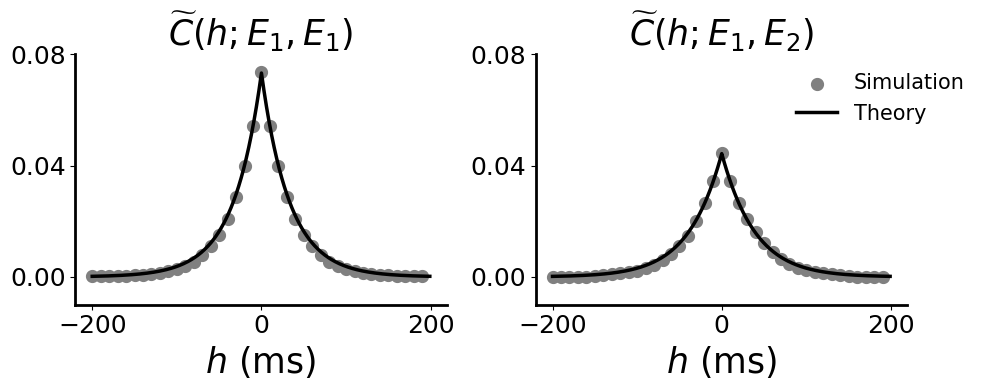

In [11]:
plt.rcParams["figure.figsize"]=10,4
fig, axs = plt.subplots(1,2)

axs[0].scatter(simLagsWindowed[::1000],aveCovv11Windowed[::1000], color='grey', linewidth=3.5, label='Simulation')
axs[0].plot(lagsTheory, CorrFn[:,0,0], color='black', linestyle='-', linewidth=2.5, label='Theory')
axs[0].set_title(r'$\widetilde{C}(h; E_1,E_1)$', fontsize=25)

axs[1].scatter(simLagsWindowed[::1000],aveCovv12Windowed[::1000], color='grey', linewidth=3.5, label='Simulation')
axs[1].plot(lagsTheory, CorrFn[:,0,1], color='black', linestyle='-', linewidth=2.5, label='Theory')
axs[1].set_title(r'$\widetilde{C}(h; E_1,E_2)$', fontsize=25)

for i in range(2):
    axs[i].spines.left.set_linewidth(2)
    axs[i].spines.bottom.set_linewidth(2)
    axs[i].spines.right.set_color('none')
    axs[i].spines.top.set_color('none')
    axs[i].set_xlabel(r'$h$ (ms)', fontsize=25)
    axs[i].xaxis.set_tick_params(labelsize=18)
    axs[i].yaxis.set_tick_params(labelsize=18)
    axs[i].set_ylim([-0.01, 0.08])
    axs[i].yaxis.set_ticks([0, 0.04, 0.08])
plt.legend(bbox_to_anchor=(.65,1), loc="upper left", fontsize=15, frameon=False)
# plt.savefig('figs/Fig2_Panel_d.eps', bbox_inches='tight')
fig.tight_layout()
plt.show()